# Knowledge Graph Project (by FORWARD Data Lab)

![logo](./logo.png)

## Part 1. ETL Pipeline

### Load libraries

In [1]:
import pyspark as sp
import numpy as np
import string
import re

### Set environment variable (optional)

In [2]:
import os
os.environ["PYSPARK_PYTHON"]="/usr/local/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"]="/usr/local/bin/python3"

### Setup cluster

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Knowledge Graph Project") \
    .master("local[*]") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

###  Load dataset

- Documents: `1.7m` documents (arXiv dataset)
- Keyword list: `100,000` keywords (FORWARD Data Lab)
- Download your documents here: https://www.kaggle.com/Cornell-University/arxiv.

In [4]:
df_keywords = spark.read.csv("./mag_cs_keywords.csv",header=True)
df_arxiv = spark.read.json("./original/arxiv-metadata-oai-snapshot.json")

In [5]:
df_keywords = df_keywords.repartition(8)
df_arxiv = df_arxiv.repartition(8)

In [6]:
df_keywords.rdd.getNumPartitions()

8

In [7]:
df_keywords.count()

104654

In [8]:
abstracts = df_arxiv.select("id","abstract")
keywords = df_keywords.select("normalizedName")

### Cleaning & Normalization

In [9]:
from pyspark.sql.functions import udf, col
from pyspark.sql import Row
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType

# get only lowercase alphabets
def strip_non_ascii(data_str):
    ''' Returns the string without non ASCII characters'''
    stripped = (c.lower() for c in data_str if 96 < ord(c.lower()) < 123 or ord(c)==32) #alphabets

    return ''.join(stripped)
# setup pyspark udf function
strip_non_ascii_udf = udf(strip_non_ascii, StringType())

In [10]:
abstracts = abstracts.withColumn('normalized', strip_non_ascii_udf(abstracts['abstract']))
abstracts = abstracts.select("id","normalized")

In [11]:
abstracts.show()

+---------+--------------------+
|       id|          normalized|
+---------+--------------------+
|0809.3647|  in this paper w...|
|0809.1984|  quantum fluctua...|
|0710.3204|  we show how com...|
|0704.3898|  we give two cla...|
|0807.4706|  let g be a grou...|
|0809.2915|  the h and zeus ...|
|0803.3905|  when designing ...|
|0807.0026|  radio telescope...|
|0804.1504|  in  an internat...|
|0802.4266|  we study group ...|
|0802.3187|  the role of neu...|
|0710.2708|  given a project...|
|0706.0677|  this is the thi...|
|0707.1652|  the pierre auge...|
|0809.1051|  we present a ve...|
|0704.3951|  ramification in...|
|0805.4670|  based on firstp...|
|0710.4428|  an asymptotic m...|
|0712.1683|  recently the in...|
|0810.0015|  experiments in ...|
+---------+--------------------+
only showing top 20 rows



### Keyword List for Query

- `keywords_dict` : Hash table is used to find whether documents contain keywords
- My frist attempt was using regular expression (re.findall()). 
- When using regular expression, there could be a time complexity issue due to unnecessary computational overhead
- To prevent optimize algorithm, we should search `from document to word`. 

In [12]:
keywords_list = list(keywords.select('normalizedName').toPandas()['normalizedName'])
keyword_dict = {word:0 for word in keywords_list}

### Extract Keyword from the keyword list

In [13]:
import re

# Define the function you want to return
def extract(s):
    all_matches = set()
    for word in s.split(" "): 
        if keyword_dict.get(word, -1) >=0: 
            keyword_dict[word] += 1
            all_matches.add(word)
    return ','.join(all_matches)

# Create the UDF, note that you need to declare the return schema matching the returned type
extract_udf = udf(extract, StringType())

# Apply it
df = abstracts.withColumn('extracted', extract_udf(abstracts['normalized']))

In [14]:
df.show()

+---------+--------------------+--------------------+
|       id|          normalized|           extracted|
+---------+--------------------+--------------------+
|0809.3647|  in this paper w...|size,algorithm,pr...|
|0809.1984|  quantum fluctua...|quantum,field,res...|
|0710.3204|  we show how com...|current,scatterin...|
|0704.3898|  we give two cla...|set,metric,functi...|
|0807.4706|  let g be a grou...|product,cluster,q...|
|0809.2915|  the h and zeus ...|scattering,mass,q...|
|0803.3905|  when designing ...|set,art,modelling...|
|0807.0026|  radio telescope...|range,leakage,pos...|
|0804.1504|  in  an internat...|imagination,refle...|
|0802.4266|  we study group ...| bimodule,skew,group|
|0802.3187|  the role of neu...|quark,phase,gauge...|
|0710.2708|  given a project...|bundle,decomposit...|
|0706.0677|  this is the thi...|geodesic,link,ser...|
|0707.1652|  the pierre auge...|pose,unit,distrib...|
|0809.1051|  we present a ve...|range,quantum,res...|
|0704.3951|  ramification in

### Drop Empty Rows where no keyword exists

In [15]:
from pyspark.sql.functions import length
df = df.filter(length('extracted')>2)

In [16]:
df.show()

+---------+--------------------+--------------------+
|       id|          normalized|           extracted|
+---------+--------------------+--------------------+
|0809.3647|  in this paper w...|size,algorithm,pr...|
|0809.1984|  quantum fluctua...|quantum,field,res...|
|0710.3204|  we show how com...|current,scatterin...|
|0704.3898|  we give two cla...|set,metric,functi...|
|0807.4706|  let g be a grou...|product,cluster,q...|
|0809.2915|  the h and zeus ...|scattering,mass,q...|
|0803.3905|  when designing ...|set,art,modelling...|
|0807.0026|  radio telescope...|range,leakage,pos...|
|0804.1504|  in  an internat...|imagination,refle...|
|0802.4266|  we study group ...| bimodule,skew,group|
|0802.3187|  the role of neu...|quark,phase,gauge...|
|0710.2708|  given a project...|bundle,decomposit...|
|0706.0677|  this is the thi...|geodesic,link,ser...|
|0707.1652|  the pierre auge...|pose,unit,distrib...|
|0809.1051|  we present a ve...|range,quantum,res...|
|0704.3951|  ramification in

$$ PMI(A,B) = \frac{P(A,B)}{P(A)*P(B)}$$

$$ P(A,B) = \frac{c((A,B), C_{\text{pairs}})}{c(C_{\text{pairs})}} $$

$$ P(A) = \frac{c(A)}{c(C)}, P(B) = \frac{c(B)}{c(C)} $$

$$ \text{where C stands for word collection} $$

### 1. Get Word Count 

- `corpus`: It is a dictionary of unigram count
      defaultdict(int,
                {'conjugate': 4041,
                 'quantum': 162709,
                 'lambda': 18154,
                 'method': 195849,
                 'quantization': 11050, 
                 ...
                 }

In [17]:
corpus_temp = df.select("extracted").rdd.repartition(32).flatMap(lambda x: (x["extracted"].split(",")))
corpus = corpus_temp.countByValue()

### 2. Get Cooccurence Count
- `corpus2` : It is a dictionary where key is tuple (pair of unigrams) and value is frequency
        defaultdict(int,
                    {('conjugate', 'quantum'): 490,
                     ('conjugate', 'lambda'): 60,
                     ('conjugate', 'method'): 606,
                     ('conjugate', 'quantization'): 82, 
                     ... 
                     }

In [18]:
rdds = df.select("extracted").rdd.repartition(32).map(lambda x: x['extracted'].split(","))

In [19]:
from itertools import combinations
corpus2_temp = rdds.flatMap(lambda x: combinations(x,2))
corpus2 = corpus2_temp.countByValue()

### 3. How to avoid bottleneck?

- Use clusters! (Amazon EMR, S3)

### 4. Save Result Here

- Uncomment to save to text file

In [20]:
# corpus_temp.repartition(8).saveAsTextFile("./corpus_final.txt")
# corpus2_temp.repartition(8).saveAsTextFile("./corpus2_final.txt")

### 5. Load From File

- Uncomment to load from file

In [21]:
# corpus = spark.sparkContext.textFile("./corpus_final.txt").countByValue()
# corpus2 = spark.sparkContext.textFile("./corpus2_final.txt").countByValue()

"""
Clean corpus when read from file
Since we are loading from a textfile, tuples are converted into strings
"""
# from collections import defaultdict
# corpus_temp = defaultdict(int)

# corpus = dict(map(lambda x: (x[0].strip(), x[1]), corpus.items()))
# for k, v in corpus2.items():
#     k1, k2 = re.sub("'", "", k.strip('"()')).split(",")
#     k2 = k2.strip()
#     w1, w2 = min(k1, k2), max(k1, k2)
#     corpus_temp[(w1, w2)] += v
# corpus2 = corpus_temp

'\nClean corpus when read from file\nSince we are loading from a textfile, tuples are converted into strings\n'

## Part 2. Graph Visualization

### Draw Graph

In [22]:
freq_threshold = 0
PMI_threshold = 10

In [23]:
import networkx as nx
import math
import pdb
G = nx.Graph()

total_word_freq = sum(corpus.values())
total_pair_freq = sum(corpus2.values())
for (n1, n2), cooccurence in corpus2.items():
    if corpus[n1] > freq_threshold and corpus[n2] > freq_threshold and cooccurence:
        pa = corpus[n1] / total_word_freq
        pb = corpus[n2] / total_word_freq
        pab = cooccurence / total_pair_freq
        
        pmi = math.log(pab/(pa*pb), 2)
        G.add_edge(n1, n2, weight=pmi)

### !! Test Your QUERY Here !!

- Type `your query` here
- Sample queries include
        gene, class, theory, stat, dimension, state

In [24]:
query = 'colonialism'
sorted(G.adj[query].items(), key=lambda x: x[1]['weight'], reverse=True)[:10]

[('patriarchy', {'weight': 21.569935731346103}),
 ('solidarity', {'weight': 17.400010729903787}),
 ('meter', {'weight': 11.037579806057254}),
 ('astronomy', {'weight': 9.556613057920654}),
 ('white', {'weight': 8.155514749599684}),
 ('center', {'weight': 7.155382616518959}),
 ('telescope', {'weight': 6.94331407898773}),
 ('impact', {'weight': 6.596238365040749}),
 ('support', {'weight': 6.590599858680719})]

- Higher than `10 pmi` demonstrates a strong relationship between the two words
- Below is the `sample pmi` table from the wikipiedia dataset. 

| word 1 | word 2 | count word 1 | count word2 | co-occurence | pmi            |
|--------|--------|--------------|-------------|--------------|----------------|
| puerto | rico   | 1938         | 1311        | 1159         | 10.0349081703  |
| car    | driver | 5578         | 2749        | 1384         | 8.41470768304  |
| it     | the    | 283891       | 3293296     | 3347         | -1.72037278119 |
| of     | and    | 1761436      | 1375396     | 1190         | -3.70663100173 |

- Reference: https://en.wikipedia.org/wiki/Pointwise_mutual_information

### Top 10 Related Words

- `Queries` and their `related keywords` are sorted here by pmi. 
- Natural science domain seems to working well

In [25]:
result = list()
for i, q in enumerate(list(G.nodes)):
    weight = sorted(G.adj[q].items(), key=lambda x: x[1]['weight'], reverse=True)[:3]
    
    if len(weight)==0:
        r1, r2, r3 = 0, 0, 0
        pmi = 0
    elif len(weight)==1:
        r1, r2, r3 = weight[0][0], 0, 0
        pmi = weight[0][1]['weight']
    elif len(weight)==2:
        r1, r2, r3 = weight[0][0], weight[1][0], 0
        pmi = weight[0][1]['weight']
    else:
        r1, r2, r3 = weight[0][0], weight[1][0], weight[2][0]
        pmi = weight[0][1]['weight']
    
    result.append((q, r1, r2, r3, pmi))

result.sort(key=lambda x: x[4], reverse=True)

for q, r1, r2, r3, _ in result[:10]:
    print("query: {}".format(q))
    print("result: {0}, {1}, {2}\n".format(r1, r2, r3))

query: spastic
result: hypertonia, reflex, muscle

query: hypertonia
result: spastic, reflex, muscle

query: jatropha
result: endophyte, colonization, crop

query: endophyte
result: jatropha, colonization, crop

query: thrombopoietin
result: thrombopoiesis, megakaryocyte, platelet

query: thrombopoiesis
result: thrombopoietin, megakaryocyte, platelet

query: megakaryocyte
result: thrombopoietin, thrombopoiesis, platelet

query: mamluk
result: terracotta, mesopotamia, lustre

query: terracotta
result: mamluk, mesopotamia, lustre

query: colonialism
result: patriarchy, solidarity, meter



### Visualization

- The final plot shows that related words form a group of cluster

In [26]:
samples = ["spastic", "hypertonia", "reflex", "muscle", "endophyte", "jatropha", "colonization", "crop", "colonialism", "patriarchy", "solidarity", "meter"]

In [27]:
matrix = list()
for i, row in enumerate(samples):
    row_temp = list()
    for j, col in enumerate(samples):
        w1, w2 = samples[i], samples[j]
        if G.adj.get(w1, 0) and G.adj[w1].get(w2, 0) and G.adj[w1][w2].get("weight", 0):
            row_temp.append(G.adj[w1][w2]["weight"])
        else:
            row_temp.append(0)
    matrix.append(row_temp)

In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
result = pca.fit_transform(matrix)

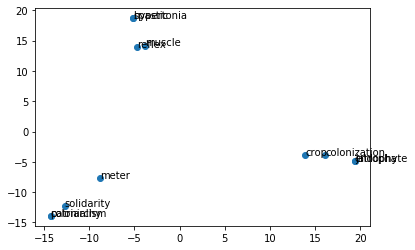

<Figure size 1080x1080 with 0 Axes>

In [30]:
from matplotlib import pyplot

pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(samples):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))

pyplot.figure(figsize=(15,15))
pyplot.show()

### Future Directions

- Tokenization
    - Include `n-gram` (2,3,4,...) extractor to extract longer keywords.
    - e.g.) keyword: computer science
    - `Phrase mining` or `Named Entity Recogntition` can be used during the process
    

- Embedding
    - Use cooccurence matrix to train word embeddings (Glove)
    - Or, load word embedding from Glove or Word2Vec and proejct to 2D plot.
    - Evalutate the similarity of two words by using `l1 distance`, `l2 distance`, or `cosine similiarity`.


- Metric
    - We may investigate `NPMI`


### References
- running pyspark in jupyter
    - https://medium.com/@Vatsal410/running-pyspark-on-an-aws-cluster-through-jupyter-notebook-fe28f6ef47a4
    - https://medium.com/@christo.lagali/run-jupyter-notebooks-with-pyspark-on-an-emr-cluster-9630ef54c4e1
    - https://towardsdatascience.com/getting-started-with-pyspark-on-amazon-emr-c85154b6b921
- reading and writing in Amazon s3
    - https://docs.cloudera.com/runtime/7.0.2/developing-spark-applications/topics/spark-examples-of-accessing-s3-data-from-spark.html
- textmining in apache spark
    - https://runawayhorse001.github.io/LearningApacheSpark/textmining.html
    - https://medium.com/@serkansakinmaz/how-to-connect-amazon-s3-via-emr-based-pyspark-42707d540881
- How to setup spark cluster in AWS
    - https://aws.amazon.com/blogs/big-data/best-practices-for-successfully-managing-memory-for-apache-spark-applications-on-amazon-emr/

- Extract keywords in document
    - https://stackoverflow.com/questions/48869922/how-to-efficiently-check-if-a-list-of-words-is-contained-in-a-spark-dataframe
    - https://stackoverflow.com/questions/46410887/pyspark-string-matching-to-create-new-column
      
- Useful tutorials
   - https://spark.apache.org/docs/1.6.3/ml-features.html
   
- Word embeddings and visualization
   - https://web.stanford.edu/class/cs224n/assignments/a1_preview/exploring_word_vectors.html
   - https://machinelearningmastery.com/develop-word-embeddings-python-gensim/  